In [33]:
import pandas as pd
from pymongo import MongoClient

# Set the path to your Excel file
file_path = '/Users/ravindu/Desktop/Project3/Resources/Stock Markets, US$.xlsx'  # Update this path
stock_data = pd.read_excel(file_path)  # Read the stock data

# Clean the data
stock_data_cleaned = stock_data.copy()

# Rename the 'Unnamed: 0' column to 'Year'
stock_data_cleaned.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)

# Remove rows where the 'Year' column is NaN
stock_data_cleaned = stock_data_cleaned[stock_data_cleaned['Year'].notna()]

# Reset the index to clean up after dropping rows
stock_data_cleaned.reset_index(drop=True, inplace=True)

# Convert the 'Year' column to integer (if required)
stock_data_cleaned['Year'] = stock_data_cleaned['Year'].astype(int)

# Replace '0.0' with NaN to avoid confusion, then fill NaN with 0 for all columns except 'Year'
stock_data_cleaned.replace(0.0, pd.NA, inplace=True)
stock_data_cleaned.iloc[:, 1:] = stock_data_cleaned.iloc[:, 1:].fillna(0)

# Check the cleaned data
print(stock_data_cleaned.head())

# Save the cleaned data to a new Excel file
stock_data_cleaned.to_excel('cleaned_stock_data.xlsx', index=False)

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')  # Update the MongoDB connection URL if necessary
db = client['stock_database']  # Use your database name
collection = db['stock_collection']  # Use your collection name

# Convert the cleaned data to a list of dictionaries (for MongoDB insertion)
stock_data_dict = stock_data_cleaned.to_dict(orient='records')

# Insert data into MongoDB
collection.insert_many(stock_data_dict)

print("Data successfully inserted into MongoDB.")


   Year  United Arab Emirates  Argentina  Australia   Austria   Belgium  \
0  1995                   0.0    0.00000   33.98690  35.29171  52.61066   
1  1996                   0.0   23.91518   40.10000  37.32716  62.57487   
2  1997                   0.0   31.96844   42.72983  39.26318  72.09075   
3  1998                   0.0   23.74431   37.92748  39.90513  96.45048   
4  1999                   0.0   20.79165   43.27264  33.73018  95.57480   

   Bulgaria  Bahrain  Bosnia and Herzegovina    Brazil  ...   Thailand  \
0       0.0      0.0                     0.0  10.99475  ...  235.65850   
1       0.0      0.0                     0.0  15.10200  ...  209.35410   
2       0.0      0.0                     0.0  24.86574  ...   93.50412   
3       0.0      0.0                     0.0  20.79932  ...   39.09179   
4       0.0      0.0                     0.0  15.82107  ...   50.58971   

    Tunisia    Turkey  Taiwan, China  Uganda    Ukraine  United States  \
0   0.00000  24.71689       83

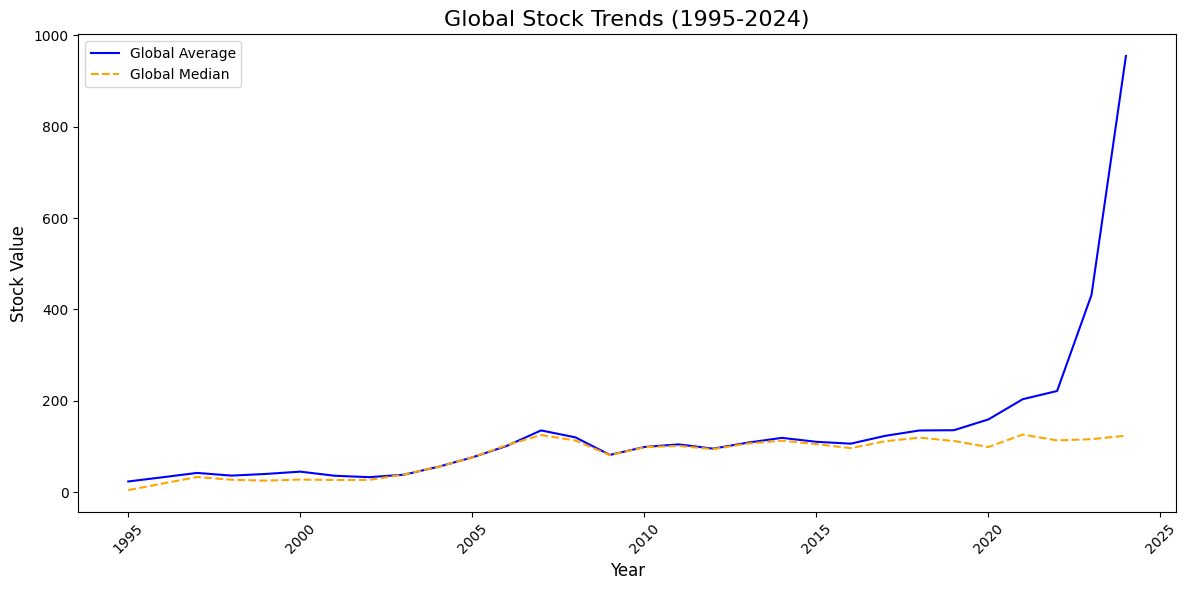

/opt/anaconda3/lib/python3.12/site-packages/mpld3/mplexporter/utils.py:68: UserWarning: line style '(0.0, None)' not understood: defaulting to solid line.
  warnings.warn("line style '{0}' not understood: "


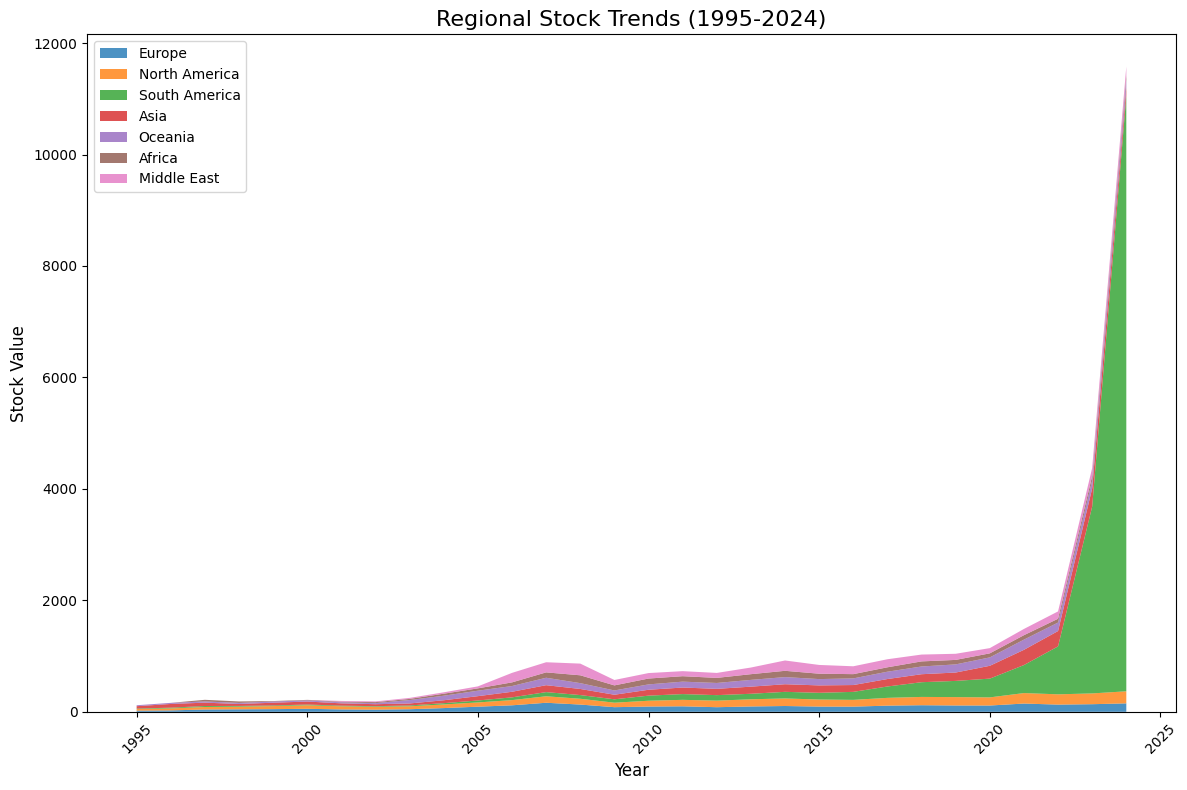

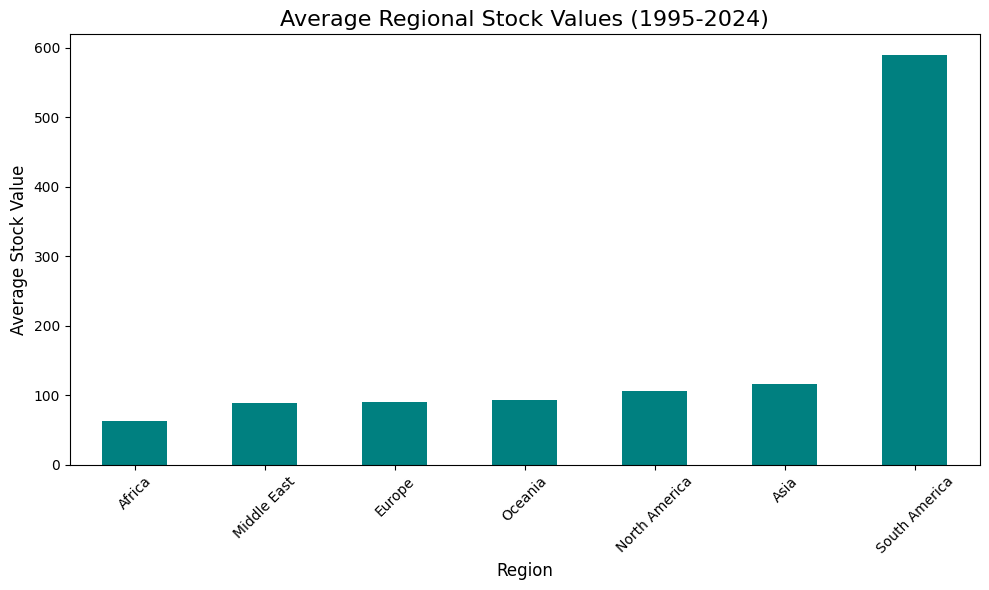

Global Averages from MongoDB:
                        _id  Year  Global Average
0  6759a9ad327057dd6b5d859c  1995       23.735486
1  6759a9ad327057dd6b5d859d  1996       32.919636
2  6759a9ad327057dd6b5d859e  1997       42.435859
3  6759a9ad327057dd6b5d859f  1998       36.529419
4  6759a9ad327057dd6b5d85a0  1999       40.178455
Regional Trends from MongoDB:
                        _id  Year     Europe  North America  South America  \
0  6759a9ad327057dd6b5d85ba  1995  20.628804      28.534790       9.206887   
1  6759a9ad327057dd6b5d85bb  1996  25.257114      35.288563      13.673332   
2  6759a9ad327057dd6b5d85bc  1997  41.515410      45.062050      17.474210   
3  6759a9ad327057dd6b5d85bd  1998  44.744460      47.501790      13.295917   
4  6759a9ad327057dd6b5d85be  1999  47.691409      54.783113      11.832387   

        Asia    Oceania     Africa  Middle East  
0  42.545568  16.993450   0.000000          0.0  
1  66.315873  20.050000   0.000000          0.0  
2  60.322504  21.3649

In [34]:


# Extract all countries (assume first column is 'Year')
all_countries = list(df.columns[1:])  # Exclude 'Year'

# Ensure the 'Year' column is treated as integers
df.loc[:, 'Year'] = df['Year'].astype(int)

# Filter the data for the years between 1995 and 2024
df_filtered = df[(df['Year'] >= 1995) & (df['Year'] <= 2024)]

# Global Aggregates - Calculate the average and median stock value globally for each year
df_filtered['Global Average'] = df_filtered[all_countries].mean(axis=1)
df_filtered['Global Median'] = df_filtered[all_countries].median(axis=1)

# Step 7: Save Global Averages to MongoDB
global_averages = df_filtered[['Year', 'Global Average']].to_dict(orient='records')
db['global_averages'].delete_many({})  # Clear collection before inserting
db['global_averages'].insert_many(global_averages)

# Step 8: Regional Trends - Define regions and group countries
regions = {
    'Europe': ['Austria', 'Belgium', 'Bulgaria', 'Bosnia and Herzegovina', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russian Federation', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'],
    'North America': ['Canada', 'United States', 'Mexico'],
    'South America': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Peru', 'Venezuela, RB'],
    'Asia': ['Bahrain', 'China', 'Hong Kong SAR, China', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Korea, Rep.', 'Malaysia', 'Pakistan', 'Philippines', 'Qatar', 'Saudi Arabia', 'Singapore', 'Sri Lanka', 'Thailand', 'Taiwan, China', 'Viet Nam'],
    'Oceania': ['Australia', 'New Zealand'],
    'Africa': ['Egypt, Arab Rep.', 'Kenya', 'Malawi', 'Morocco', 'Nigeria', 'South Africa', 'Tunisia', 'Uganda'],
    'Middle East': ['United Arab Emirates', 'Oman'],
}

# Calculate regional averages
df_filtered_regions = pd.DataFrame()
df_filtered_regions['Year'] = df_filtered['Year']

for region, countries in regions.items():
    valid_countries = [country for country in countries if country in df_filtered.columns]
    df_filtered_regions[region] = df_filtered[valid_countries].mean(axis=1)

# Step 9: Save Regional Trends to MongoDB
regional_trends = df_filtered_regions.to_dict(orient='records')
db['regional_trends'].delete_many({})  # Clear collection before inserting
db['regional_trends'].insert_many(regional_trends)

# Step 10: Plotting Global Trends
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Year'], df_filtered['Global Average'], label='Global Average', color='blue', linestyle='-')
plt.plot(df_filtered['Year'], df_filtered['Global Median'], label='Global Median', color='orange', linestyle='--')

# Add labels and titles
plt.title('Global Stock Trends (1995-2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Stock Value', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('global_trends_plot.png')
mpld3.save_html(plt.gcf(), 'global_trends_plot.html')
plt.show()

# Step 11: Plot Regional Trends (Stacked Area Chart)
plt.figure(figsize=(12, 8))
plt.stackplot(
    df_filtered_regions['Year'],
    [df_filtered_regions[region] for region in regions.keys()],
    labels=regions.keys(),
    alpha=0.8
)
plt.title('Regional Stock Trends (1995-2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Stock Value', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('regional_trends_plot.png')
mpld3.save_html(plt.gcf(), 'regional_trends_plot.html')
plt.show()

# Step 12: Grouped Bar Plot for Yearly Regional Averages
regional_averages = df_filtered_regions.drop(columns=['Year']).mean().sort_values()

plt.figure(figsize=(10, 6))
regional_averages.plot(kind='bar', color='teal')
plt.title('Average Regional Stock Values (1995-2024)', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Stock Value', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('regional_bar_plot.png')
mpld3.save_html(plt.gcf(), 'regional_bar_plot.html')
plt.show()

# Step 13: Retrieve and Print Data from MongoDB
global_averages_from_db = pd.DataFrame(list(db['global_averages'].find()))
print("Global Averages from MongoDB:")
print(global_averages_from_db.head())

regional_trends_from_db = pd.DataFrame(list(db['regional_trends'].find()))
print("Regional Trends from MongoDB:")
print(regional_trends_from_db.head())

print("All plots saved as PNG and HTML files.")
